## Predicting player points
As we have generated a prediction of whether a player will play or not, we will only consider those players which have played when we build our point prediction model. This is because our goal is to use our results to decide upon the players we should have in our team for the next gameweek. If we frame our problem as 'how many points will each player play **assuming they play**' there are not issues, as we can use our above prediction to filter to those likely to play. This serves the purpose of reducing the imbalance in our data, as the earlier exploratory notebook showed many players do not play, leading to a large inflation of zero scores. 

In [2]:
import os
import pickle
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.model_selection import GroupKFold, LeaveOneGroupOut, LeavePGroupsOut, GroupShuffleSplit
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, brier_score_loss, r2_score, make_scorer, log_loss
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.exceptions import DataConversionWarning

warnings.filterwarnings(action='ignore', category=DataConversionWarning)
%matplotlib inline
pd.options.display.max_columns = None

players_train = pd.read_csv('../data/model_data/final_train_data.csv')
players_test = pd.read_csv('../data/model_data/final_test_data.csv')

### Classification approach
There is considerable flexibility in how this can be approached. To begin with, I will try to classify players into whether they are likely to score highly (five or more points) in a gameweek. 

In all my training (and intermediate validation and test) sets, I will only consider those who play, as discussed above.

A reminder of the data.

In [3]:
players_train.head()

,player_id,first_name,second_name,team_id,team_difficulty,gameweek,kickoff_hour,kickoff_hour_cos,kickoff_hour_sin,kickoff_weekday,kickoff_weekday_cos,kickoff_weekday_sin,fixture_id,is_home,opponent_team,opponent_team_strength,opponent_difficulty,opponent_strength_ha_overall,opponent_strength_ha_attack,opponent_strength_ha_defence,target_total_points,target_minutes,target_goals_scored,target_goals_conceded,selected,value,value_change,custom_form,transfers_balance,transfers_in,transfers_out,team_strength,team_strength_ha_overall,team_strength_ha_attack,team_strength_ha_defence,prev_assists,prev_attempted_passes,prev_big_chances_created,prev_big_chances_missed,prev_bonus,prev_bps,prev_clean_sheets,prev_clearances_blocks_interceptions,prev_completed_passes,prev_creativity,prev_draw,prev_dribbles,prev_errors_leading_to_goal,prev_errors_leading_to_goal_attempt,prev_fouls,prev_goals_conceded,prev_goals_scored,prev_ict_index,prev_influence,prev_key_passes,prev_kickoff_hour,prev_kickoff_hour_cos,prev_kickoff_hour_sin,prev_kickoff_weekday,prev_kickoff_weekday_cos,prev_kickoff_weekday_sin,prev_loss,prev_minutes,prev_offside,prev_open_play_crosses,prev_opponent_score,prev_opponent_team,prev_own_goals,prev_penalties_conceded,prev_penalties_missed,prev_penalties_saved,prev_recoveries,prev_red_cards,prev_saves,prev_tackled,prev_tackles,prev_target_missed,prev_team_score,prev_threat,prev_total_points,prev_win,prev_winning_goals,prev_yellow_cards,roll_goals_scored,roll_mean_points,roll_minutes,roll_team_conceded,roll_team_points,roll_team_scored,roll_total_points,roll_unique_scorers,team_prev_mean_points,team_prev_result_points,team_prev_total_points,team_prev_unique_scorers,use_row,predict_row,model_row,played_at_all,event_day,position_FWD,position_GKP,position_MID,team_short_BHA,team_short_BOU,team_short_BUR,team_short_CAR,team_short_CHE,team_short_CRY,team_short_EVE,team_short_FUL,team_short_HUD,team_short_LEI,team_short_LIV,team_short_MCI,team_short_MUN,team_short_NEW,team_short_SOU,team_short_TOT,team_short_WAT,team_short_WHU,team_short_WOL,opponent_team_short_BHA,opponent_team_short_BOU,opponent_team_short_BUR,opponent_team_short_CAR,opponent_team_short_CHE,opponent_team_short_CRY,opponent_team_short_EVE,opponent_team_short_FUL,opponent_team_short_HUD,opponent_team_short_LEI,opponent_team_short_LIV,opponent_team_short_MCI,opponent_team_short_MUN,opponent_team_short_NEW,opponent_team_short_SOU,opponent_team_short_TOT,opponent_team_short_WAT,opponent_team_short_WHU,opponent_team_short_WOL,target_ge5
0,1,Petr,Cech,1,2,4,12,-1.000000,1.224647e-16,6,0.623490,-0.781831,33,False,5,2.0,4,1080.0,1060.0,1090.0,1.0,90.0,0.0,2.0,123566.0,50.0,0.0,22.333333,9582.0,19332.0,9750.0,4.0,1320.0,1270.0,1340.0,0.0,24.0,0.0,0.0,0.0,17.0,0.0,0.0,20.0,0.0,False,0.0,0.0,0.0,0.0,1.0,0.0,2.8,27.8,0.0,14.0,-0.866025,-5.000000e-01,5.0,-0.222521,-0.974928,False,90.0,0.0,0.0,1.0,19.0,0.0,0.0,0.0,0.0,10.0,0.0,4.0,0.0,0.0,0.0,3.0,0.0,3.0,True,0.0,0.0,0.0,2.380952,90.0,2.000000,1.0,1.666667,33.333333,1.333333,3.357143,3.0,47.0,2.0,True,False,True,True,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False
1,1,Petr,Cech,1,3,5,14,-0.866025,-5.000000e-01,5,-0.222521,-0.974928,46,False,15,3.0,4,1120.0,1110.0,1050.0,2.0,90.0,0.0,1.0,123310.0,50.0,0.0,17.000000,-3297.0,8837.0,12134.0,4.0,1320.0,1270.0,1340.0,0.0,38.0,0.0,0.0,0.0,8.0,0.0,0.0,24.0,0.0,True,0.0,0.0,2.0,0.0,2.0,0.0,0.2,2.4,0.0,12.0,-1.000000,1.224647e-16,6.0,0.623490,-0.781831,False,90.0,0.0,0.0,3.0,5.0,0.0,0.0,0.0,0.0,8.0,0.0,1.0,0.0,0.0,0.0,3.0,0.0,1.0,False,0.0,0.0,0.0,3.000000,90.0,2.000000,2.0,2.666667,42.000000,2.333333,3.214286,3.0,45.0,3.0,True,False,True,True,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,False
2,1,Petr,Cech,1,2,6,15,-0.707107,-7.071068e-01,6,0.623490,-0.781831,51,True,8,3.0,4,1090.0,1070.0,1140.0,11.0,90.0,0.0,0.0,124787.0,50.0,0.0,12.666667,-797.0,6593.0,7390.0,4.0,1260.0,1240.0,1310.0,0.0,33.0,0.0,0.0,0.0,13.0,0.0

Setting up the target columns for classification - we are predicting whether a player will score five or more points in a game.

In [4]:
# Rows we can use in the training set (i.e. they have a non-missing response)
full_training_data = players_train[~players_train.target_total_points.isna() &
                                   players_train.played_at_all].copy()
full_training_data['target_gt5_points'] = full_training_data.target_total_points >=5

players_test['played_at_all'] = players_test['target_minutes'] > 0

full_test_data = players_test[~players_test.target_total_points.isna() &
                                   players_test.played_at_all].copy()
full_test_data['target_gt5_points'] = full_test_data.target_total_points >=5

In [5]:
print(f"Percentage of player rows with player scoring five or more points {np.mean(full_training_data.target_gt5_points):.1%}")

Percentage of player rows with player scoring five or more points 22.2%


This is not too imbalanced. Whilst I will not resample the data, I will switch my model evaluation metric to be the ROC area under the curve, which is invariant to classification thresholds and generally is more useful in cases with a minority class. I could oversample the positive class to address the imbalance at a future point, though at the moment twenty-odd percent may allow a performant classifier to be trained.

I will also keep the brier score in mind as my idea at the moment is for the final output to be a probability rather than classification as this may help the end user in their decision of whether to select a player based on this model.

In [14]:
# Player_ids of those playing
training_player_ids = full_training_data.player_id
test_player_ids = full_test_data.player_id

# The column to predict
target = 'target_gt5_points'

# Columns to use as features
all_features = [col for col in full_training_data if col not in
               ['player_id',
               'first_name',
               'second_name',
               'team_id',
               'gameweek',
               'fixture_id',
               'opponent_team',
                'selected',
                'use_row',
                'model_row',
                'played_at_all',
                'kickoff_hour',
                'kickoff_weekday',
                'prev_kickoff_hour',
                'prev_kickoff_weekday'
               ]
                and not col.startswith('target')
               ]

### Basic model
I will start off with a simple logistic regression model with the only preprocessing being variable standardisation. Note that, similar to the notebook on whether a player will play, I have to split the data while taking into account groups (i.e. players). This means we will avoid biased estimates of classifier metrics due to leakage (player) from the test set not taken into account by a variable.
In future, it might be worth investigating the effect of including player as a variable in the model. The simplest approach would be to one hot encode, though this will heavily increase the dimensionality of the dataset (adding 500 binary columns to the 140-odd in our dataset). More complicated approaches where panel data is taken into account (including things such as mixed effects models) might be worth looking into in the future.

In [15]:
# Perform the split by taking into account 'grouping' within the data (players)
train_ids, test_ids = train_test_split(training_player_ids.unique(), test_size=0.7)

# Split according to the above
train_data = full_training_data.loc[full_training_data.player_id.isin(train_ids), all_features].copy()
train_target = full_training_data.loc[full_training_data.player_id.isin(train_ids), target]
test_data = full_training_data.loc[full_training_data.player_id.isin(test_ids), all_features].copy()
test_target = full_training_data.loc[full_training_data.player_id.isin(test_ids), target]

column_names = list(train_data.columns)

# Simple scaling of the data
ss = StandardScaler()

# Standardise and transform to numpy arrays
X_train = ss.fit_transform(train_data.values)
X_test = ss.transform(test_data.values)
y_train = train_target.values
y_test = test_target.values

In [16]:
lr = LogisticRegression()

lr.fit(X_train, y_train)

preds_train_play = lr.predict_proba(X_train)[:, 1]
preds_test_play = lr.predict_proba(X_test)[:, 1]

print('ROC AUC of simple classifier on train: {:.2f}'.format(roc_auc_score(y_train, preds_train_play)))
print('ROC AUC of simple classifier on test: {:.2f}'.format(roc_auc_score(y_test, preds_test_play)))

print('\nBrier score of simple classifier on train: {:.2f}'.format(brier_score_loss(y_train, preds_train_play)))
print('Brier score of simple classifier on test: {:.2f}'.format(brier_score_loss(y_test, preds_test_play)))

ROC AUC of simple classifier on train: 0.77
ROC AUC of simple classifier on test: 0.67

Brier score of simple classifier on train: 0.14
Brier score of simple classifier on test: 0.17


This is not too bad, though there is some overfitting suggested by the AUC. This is better than I thought it would be (seeing how little correlation there are between features and the response - see the previous notebooks); I worried any models would be little better than random guessing!

For the sake of interest, seeing how PCA has not run yet, I will see which variables affect the predictions the most. These are generated from the regression coefficients which, seeing how the features have been scaled, should be comparable.

In [17]:
coeffs = pd.DataFrame({'coeff': np.squeeze(lr.coef_),
                      'coeff_abs': np.abs(np.squeeze(lr.coef_))}, index=all_features)
coeffs.sort_values('coeff_abs', ascending=False).head(20)

,coeff,coeff_abs
opponent_strength_ha_overall,-0.653836,0.653836
prev_total_points,0.626304,0.626304
prev_bps,-0.558899,0.558899
position_MID,-0.555907,0.555907
prev_attempted_passes,-0.512385,0.512385
team_short_LIV,0.450456,0.450456
value,0.413058,0.413058
team_short_MCI,0.388616,0.388616
prev_minutes,0.348210,0.348210
team_short_WOL,0.307868,0.307868


These coefficients make sense to a degree. While we can see that, for example, when `opponent_strength_ha_overall` (the strength of the opponent teams) is high, players are less likely to score highly, which makes intuitive sense. Similarly, if a player has previously scored many points the model predicts them to continue (but not drastically) the good form. There is a similar story for value; you might expect more expensive players to score more! The better teams' players are also more likely to score more than five points, according to the model. Some of the other coefficients make less sense. For example,  forwards and midfielders are less likely to score five or more points as they have negative coefficients. This is surprising to me, but looking back at the exploratory analysis notebook plots, this does seem reasonable.

### Different models
From the above coefficients, we can at least determine a base model is functioning to, at least an extent, reasonably. However, this is just a simple model; now I will now try different algorithms, tuning hyperparameters, and resolving correlation between features (which is likely degrading the above model). I will do the latter using principal component analysis, which means interpreting coefficients going forward will be more of a challenge. Again, pca will be done by using only the components making up 95% of the total variance in the data.

To compare between models, I will use the same method as in the modelling whether a player plays notebook; nested cross validation.

In [32]:
# Now I'm using a proper cross-validation scheme, I will use the full set of training (and validation data). We still have a
# separate hold-out set not used here.
X = full_training_data.loc[:, all_features]
y = full_training_data.loc[:, target]
grps = full_training_data.loc[:, 'player_id']

def cross_val_scorer_grouped(estimator, params, X, y=None, groups=None, scoring='accuracy', scorer=accuracy_score,
                             cv_outer=5, cv_inner='warn', test_split_outer=0.2, gs_verbosity=1):
    
    # This object creates splits which take the groups into account (e.g. a group can not appear in both the training
    # and test sets)
    gss = GroupShuffleSplit(n_splits=cv_outer, test_size=test_split_outer)
    
    # For each cross validation fold, calculate the accuracy of a tuned (inner cross validation classifier) defined by
    # the input estimator
    scores = np.zeros(cv_outer)
    for i, (train, test) in enumerate(gss.split(X, y, groups=groups)):
        # Subset data to be used to train and validate for this fold
        X_train = X[train, :]
        X_test = X[test, :]
        y_train = y[train]
        y_test = y[test]
        g_train = groups[train]
        
        # Fit the model for this fold's training data
        gs = GridSearchCV(estimator=estimator, param_grid=params, scoring=scoring, cv=cv_inner, verbose=gs_verbosity)
        gs.fit(X_train, y_train, groups=g_train)
        preds = gs.predict(X_test)
        
        # Get the score for this fold
        scores[i] = scorer(y_test, preds)
        print('Fold {} complete'.format(i))
        
    return scores

# Logistic regression - tune different regularisations
pipe_lr = Pipeline([('ss', StandardScaler()),
                ('pca', PCA(n_components=0.95, svd_solver='full')),
                ('sbf', SelectKBest(f_classif, k=10)),
                ('clf', LogisticRegression())])
params_lr = {'clf__penalty': ['l1', 'l2'],
         'clf__C': np.logspace(-3, 3, 7)}

# Decision tree
pipe_dt = Pipeline([('ss', StandardScaler()),
                ('pca', PCA(n_components=0.95, svd_solver='full')),
                ('clf', DecisionTreeClassifier())])
params_dt = {'clf__max_depth': np.linspace(1, 20, 20),
                #'clf__min_samples_split': np.linspace(0.1, 1, 10)
               }

# Random forest
pipe_rf = Pipeline([('ss', StandardScaler()),
                ('pca', PCA(n_components=0.95, svd_solver='full')),
                ('sbf', SelectKBest(f_classif, k=10)),
                ('clf', RandomForestClassifier())])
params_rf = {'clf__max_depth': np.linspace(1, 10, 5)
               }

# Adaptive boosting
pipe_ad = Pipeline([('ss', StandardScaler()),
                ('pca', PCA(n_components=0.95, svd_solver='full')),
                ('clf', AdaBoostClassifier())])
params_ad = {'clf__n_estimators': [2, 5, 10, 50, 100, 250, 500, 1000]
               },

# Support vector classifier
pipe_sv = Pipeline([('ss', StandardScaler()),
                ('pca', PCA(n_components=0.95, svd_solver='full')),
                ('clf', SVC())])
params_sv = {'clf__C': np.logspace(-3, 1, 5),
               'clf__gamma': np.logspace(-3, 0, 4),
               #'clf__kernel': ['linear', 'rbf'],
               'clf__kernel': ['rbf']
               }

# K-nearest neighbours
pipe_kn = Pipeline([('ss', StandardScaler()),
                ('pca', PCA(n_components=0.95, svd_solver='full')),
                ('clf', KNeighborsClassifier())])
params_kn = {'clf__n_neighbors': [1, 5, 10, 20, 50]
               }

# The splitting scheme for the inner cross validation
gkf = GroupKFold(n_splits=5)

# The metric to optimise for
score_metric = 'roc_auc'

In [19]:
#brier_scorer = make_scorer(brier_score_loss, greater_is_better=False, needs_proba=True, needs_threshold=False, pos_label=1)
#log_loss_scorer = make_scorer(log_loss)
scores_lr = cross_val_scorer_grouped(pipe_lr, params_lr, X.values, y.values, groups=grps.values,
                                     scoring=score_metric, cv_inner=gkf, gs_verbosity=1)

Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:   14.5s finished


Fold 0 complete
Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:   13.9s finished


Fold 1 complete
Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:   14.2s finished


Fold 2 complete
Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:   13.9s finished


Fold 3 complete
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fold 4 complete


[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:   13.8s finished


In [24]:
scores_kn = cross_val_scorer_grouped(pipe_kn, params_kn, X.values, y.values, groups=grps.values,
                                     scoring=score_metric, cv_inner=gkf, gs_verbosity=1)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:  1.4min finished


Fold 0 complete
Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:  1.3min finished


Fold 1 complete
Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:  1.3min finished


Fold 2 complete
Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:  1.4min finished


Fold 3 complete
Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:  1.4min finished


Fold 4 complete


In [27]:
scores_rf = cross_val_scorer_grouped(pipe_rf, params_rf, X.values, y.values, groups=grps.values,
                                     scoring=score_metric, cv_inner=gkf, gs_verbosity=1)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    7.8s finished


Fold 0 complete
Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    9.2s finished


Fold 1 complete
Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    8.8s finished


Fold 2 complete
Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    8.4s finished


Fold 3 complete
Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    8.8s finished


Fold 4 complete


In [33]:
scores_dt = cross_val_scorer_grouped(pipe_dt, params_dt, X.values, y.values, groups=grps.values,
                                     scoring=score_metric, cv_inner=gkf, gs_verbosity=1)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   59.2s finished


Fold 0 complete
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   59.6s finished


Fold 1 complete
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   58.3s finished


Fold 2 complete
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  1.0min finished


Fold 3 complete
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  1.0min finished


Fold 4 complete


In [ ]:
scores_ad = cross_val_scorer_grouped(pipe_ad, params_ad, X.values, y.values, groups=grps.values,
                                     scoring=score_metric, cv_inner=gkf, gs_verbosity=1)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:  6.8min finished


Fold 0 complete
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:  6.7min finished


Fold 1 complete
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:  6.3min finished


Fold 2 complete
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:  6.2min finished


Fold 3 complete
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:  6.2min finished


Fold 4 complete


In [ ]:
scores_sv = cross_val_scorer_grouped(pipe_sv, params_sv, X.values, y.values, groups=grps.values,
                                     scoring=score_metric, cv_inner=gkf, gs_verbosity=1)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


#### Comparing the different algorithm results

In [ ]:
print('Nested CV {} for logistic regression: {:.4f} +/- {:.4f}'
      .format(score_metric, np.mean(scores_lr), np.std(scores_lr)))
print('Nested CV accuracy for decision tree: {:.4f} +/- {:.4f}'
      .format(np.mean(scores_dt), np.std(scores_dt)))
print('Nested CV accuracy for random forest: {:.4f} +/- {:.4f}'
      .format(np.mean(scores_rf), np.std(scores_rf)))
print('Nested CV accuracy for adaboost: {:.4f} +/- {:.4f}'
      .format(np.mean(scores_ad), np.std(scores_ad)))
print('Nested CV accuracy for support vector machine: {:.4f} +/- {:.4f}'
      .format(np.mean(scores_sv), np.std(scores_sv)))
print('Nested CV {} for knn: {:.4f} +/- {:.4f}'
      .format(score_metric, np.mean(scores_kn), np.std(scores_kn)))

From this, we can see the best performing model (taking parameter tuning into account) is **INSERT HERE AFTER TRAINING**. I will choose and refit this model on the entire training dataset using grid search to again find the optimal hyperparameters.

In [31]:
pipe_final = Pipeline([('ss', StandardScaler()),
                ('pca', PCA(n_components=0.95, svd_solver='full')),
                ('sbf', SelectKBest(f_classif, k=10)),
                ('clf', LogisticRegression())])
params_final = {'clf__penalty': ['l1', 'l2'],
         'clf__C': np.logspace(-3, 3, 7)}

gs_final = GridSearchCV(estimator=pipe_final, param_grid=params_final, scoring='neg_log_loss', cv=gkf, verbose=1)
gs_final.fit(X, y, groups=grps)

Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:   19.7s finished


GridSearchCV(cv=GroupKFold(n_splits=5), error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('ss', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=0.95, random_state=None,
  svd_solver='full', tol=0.0, whiten=False)), ('sbf', SelectKBest(k=10, score_func=<function f_classif at 0x000001A963AEE6A8>)), ('clf', Logist...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'clf__penalty': ['l1', 'l2'], 'clf__C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_log_loss', verbose=1)

Now to make the final predictions on the training and testing datasets.

In [34]:
X_test = full_test_data.loc[:, all_features]
y_test = full_test_data.loc[:, target]
grps_test = full_test_data.loc[:, 'player_id']

preds_final_train = gs_final.predict_proba(X)[:, 1]
preds_final_test = gs_final.predict_proba(X_test)[:, 1]

print('ROC AUC of final classifier on train: {:.2%}'.format(roc_auc_score(y, preds_final_train)))
print('ROC AUC of final classifier on test: {:.2%}'.format(roc_auc_score(y_test, preds_final_test)))

print('\nBrier score of final classifier on train: {:.2f}'.format(brier_score_loss(y, preds_final_train)))
print('Brier score of final classifier on test: {:.2f}'.format(brier_score_loss(y_test, preds_final_test)))

ROC AUC of final classifier on train: 67.70%
ROC AUC of final classifier on test: 70.77%
Brier score of final classifier on train: 0.16
Brier score of final classifier on test: 0.18
Neg. log loss of final classifier on train: -0.50
Neg. log loss of final classifier on test: -0.53


Saving the model.

In [15]:
model_all = {'feature_columns': all_features,
             'target_column': target,
             'model': gs_final}
    
with open('../models/points/model_classification.pkl', 'wb') as f:
    pickle.dump(model_all, f)

#### Analysing the results
It is worth taking a few minutes to look at what the model has done.

First, while having used the pca components in the models means we cannot directly examine which features have had the biggest impact on the model. However, we can examine the correlation between each variable and the predicted response (in terms of the percentage), and use this as a proxy.

In [37]:
# get predicted percentages
probs_train = gs_final.predict_proba(X)

# Construct a new dataset from the training frame and the predictions
analyse_features = full_training_data.copy()
analyse_features.columns = ['mod_' + col if col in all_features else col for col in analyse_features.columns]
analyse_features.insert(3, 'prob_of_playing', probs_train[:, 1])
analyse_features.insert(4, 'correct', (analyse_features.prob_of_playing > 0.5) & (analyse_features.target_minutes > 0))

# Correlation between each feature in the model and the predicted probability
corr_cols = analyse_features[[col for col in analyse_features.columns if col.startswith(('prob_', 'mod_'))]].corr()

# Show above
features_corr = pd.DataFrame(corr_cols.iloc[1:, 0]).rename(columns={'prob_of_playing': 'correlation'})
features_corr['abs_correlation'] = features_corr['correlation'].abs()
features_corr.sort_values('abs_correlation', ascending=False).head(20)

,correlation,abs_correlation
mod_opponent_strength_ha_overall,-0.541849,0.541849
mod_opponent_strength_ha_attack,-0.536345,0.536345
mod_opponent_strength_ha_defence,-0.532147,0.532147
mod_team_difficulty,-0.530821,0.530821
mod_opponent_team_strength,-0.513542,0.513542
mod_value,0.481555,0.481555
mod_custom_form,0.454476,0.454476
mod_prev_ict_index,0.453046,0.453046
mod_prev_threat,0.429354,0.429354
mod_roll_goals_scored,0.416269,0.416269


# TEXT HERE FOR ABOVE

In [38]:
# Get probabilities for the test set
probs_test = gs_final.predict_proba(X_test)

# Add columns describing the probability for each player playing in a gameweek to the player dataframe, a variable
# denoting whether the prediction is correct (assuming a 50% cut-off), and adding a 'mod_' prefix to those columns
# used in the modelling.
analyse_by_eye = full_test_data.copy()
analyse_by_eye.columns = ['mod_' + col if col in all_features else col for col in analyse_by_eye.columns]
analyse_by_eye.insert(3, 'prob_of_scoring_more_than_5', probs_test[:, 1])
analyse_by_eye.insert(4, 'total_points_scored', analyse_by_eye.target_total_points)
analyse_by_eye.insert(5, 'correct', ((analyse_by_eye.prob_of_scoring_more_than_5 > 0.5) & 
                      (analyse_by_eye.target_total_points >= 5)) | ((analyse_by_eye.prob_of_scoring_more_than_5 < 0.5) & 
                      (analyse_by_eye.target_total_points < 5)))


# Show a random selection
analyse_by_eye.sample(20)

,player_id,first_name,second_name,prob_of_scoring_more_than_5,total_points_scored,correct,team_id,mod_team_difficulty,gameweek,mod_kickoff_hour,mod_kickoff_hour_cos,mod_kickoff_hour_sin,mod_kickoff_weekday,mod_kickoff_weekday_cos,mod_kickoff_weekday_sin,fixture_id,mod_is_home,opponent_team,mod_opponent_team_strength,mod_opponent_difficulty,mod_opponent_strength_ha_overall,mod_opponent_strength_ha_attack,mod_opponent_strength_ha_defence,target_total_points,target_minutes,target_goals_scored,target_goals_conceded,selected,mod_value,mod_value_change,mod_custom_form,mod_transfers_balance,mod_transfers_in,mod_transfers_out,mod_team_strength,mod_team_strength_ha_overall,mod_team_strength_ha_attack,mod_team_strength_ha_defence,mod_prev_assists,mod_prev_attempted_passes,mod_prev_big_chances_created,mod_prev_big_chances_missed,mod_prev_bonus,mod_prev_bps,mod_prev_clean_sheets,mod_prev_clearances_blocks_interceptions,mod_prev_completed_passes,mod_prev_creativity,mod_prev_draw,mod_prev_dribbles,mod_prev_errors_leading_to_goal,mod_prev_errors_leading_to_goal_attempt,mod_prev_fouls,mod_prev_goals_conceded,mod_prev_goals_scored,mod_prev_ict_index,mod_prev_influence,mod_prev_key_passes,mod_prev_kickoff_hour,mod_prev_kickoff_hour_cos,mod_prev_kickoff_hour_sin,mod_prev_kickoff_weekday,mod_prev_kickoff_weekday_cos,mod_prev_kickoff_weekday_sin,mod_prev_loss,mod_prev_minutes,mod_prev_offside,mod_prev_open_play_crosses,mod_prev_opponent_score,mod_prev_opponent_team,mod_prev_own_goals,mod_prev_penalties_conceded,mod_prev_penalties_missed,mod_prev_penalties_saved,mod_prev_recoveries,mod_prev_red_cards,mod_prev_saves,mod_prev_tackled,mod_prev_tackles,mod_prev_target_missed,mod_prev_team_score,mod_prev_threat,mod_prev_total_points,mod_prev_win,mod_prev_winning_goals,mod_prev_yellow_cards,mod_roll_goals_scored,mod_roll_mean_points,mod_roll_minutes,mod_roll_team_conceded,mod_roll_team_points,mod_roll_team_scored,mod_roll_total_points,mod_roll_unique_scorers,mod_team_prev_mean_points,mod_team_prev_result_points,mod_team_prev_total_points,mod_team_prev_unique_scorers,use_row,mod_predict_row,model_row,mod_event_day,mod_position_FWD,mod_position_GKP,mod_position_MID,mod_team_short_BHA,mod_team_short_BOU,mod_team_short_BUR,mod_team_short_CAR,mod_team_short_CHE,mod_team_short_CRY,mod_team_short_EVE,mod_team_short_FUL,mod_team_short_HUD,mod_team_short_LEI,mod_team_short_LIV,mod_team_short_MCI,mod_team_short_MUN,mod_team_short_NEW,mod_team_short_SOU,mod_team_short_TOT,mod_team_short_WAT,mod_team_short_WHU,mod_team_short_WOL,mod_opponent_team_short_BHA,mod_opponent_team_short_BOU,mod_opponent_team_short_BUR,mod_opponent_team_short_CAR,mod_opponent_team_short_CHE,mod_opponent_team_short_CRY,mod_opponent_team_short_EVE,mod_opponent_team_short_FUL,mod_opponent_team_short_HUD,mod_opponent_team_short_LEI,mod_opponent_team_short_LIV,mod_opponent_team_short_MCI,mod_opponent_team_short_MUN,mod_opponent_team_short_NEW,mod_opponent_team_short_SOU,mod_opponent_team_short_TOT,mod_opponent_team_short_WAT,mod_opponent_team_short_WHU,mod_opponent_team_short_WOL,target_ge5,played_at_all,target_gt5_points
1268,197,Florent,Hadergjonaj,0.142338,2.0,True,10,3,12,15,-0.707107,-7.071068e-01,5,-0.222521,-0.974928,115,True,19,3.0,2,1100.0,1090.0,1120.0,2.0,90.0,0.0,1.0,4081.0,44.0,0.0,11.666667,-42.0,90.0,132.0,2.0,1010.0,1030.0,990.0,0.0,42.0,0.0,0.0,0.0,23.0,1.0,4.0,28.0,14.2,False,1.0,0.0,0.0,0.0,0.0,0.0,3.0,13.8,1.0,20.0,5.000000e-01,-8.660254e-01,0.0,1.000000,0.000000,False,90.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,1.0,0.0,0.0,1.0,2.0,6.0,True,0.0,0.0,0.000000,2.500000,52.666667,1.333333,1.000000,0.333333,35.000000,0.000000,4.357143,3.0,61.0,0.0,True,False,True,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,False,True,False
64,5,Nacho,Monreal,0.201082,8.0,False,1,3,34,19,0.258819,-9.659258e-01,0,1.000000,0.000000,340,False,18,3.0,4,1110.0,1100.0,1150.0,8.0,90.0,0.0,0.0,68097.0,54.0,0.0,20.000000,5730.0,9462.0,3732.0,4.0,1320.0,1270.0,134

In [40]:
# Show the top 20 by predicted percentage
analyse_by_eye.sort_values('prob_of_scoring_more_than_5', ascending=False).head(50)

,player_id,first_name,second_name,prob_of_scoring_more_than_5,total_points_scored,correct,team_id,mod_team_difficulty,gameweek,mod_kickoff_hour,mod_kickoff_hour_cos,mod_kickoff_hour_sin,mod_kickoff_weekday,mod_kickoff_weekday_cos,mod_kickoff_weekday_sin,fixture_id,mod_is_home,opponent_team,mod_opponent_team_strength,mod_opponent_difficulty,mod_opponent_strength_ha_overall,mod_opponent_strength_ha_attack,mod_opponent_strength_ha_defence,target_total_points,target_minutes,target_goals_scored,target_goals_conceded,selected,mod_value,mod_value_change,mod_custom_form,mod_transfers_balance,mod_transfers_in,mod_transfers_out,mod_team_strength,mod_team_strength_ha_overall,mod_team_strength_ha_attack,mod_team_strength_ha_defence,mod_prev_assists,mod_prev_attempted_passes,mod_prev_big_chances_created,mod_prev_big_chances_missed,mod_prev_bonus,mod_prev_bps,mod_prev_clean_sheets,mod_prev_clearances_blocks_interceptions,mod_prev_completed_passes,mod_prev_creativity,mod_prev_draw,mod_prev_dribbles,mod_prev_errors_leading_to_goal,mod_prev_errors_leading_to_goal_attempt,mod_prev_fouls,mod_prev_goals_conceded,mod_prev_goals_scored,mod_prev_ict_index,mod_prev_influence,mod_prev_key_passes,mod_prev_kickoff_hour,mod_prev_kickoff_hour_cos,mod_prev_kickoff_hour_sin,mod_prev_kickoff_weekday,mod_prev_kickoff_weekday_cos,mod_prev_kickoff_weekday_sin,mod_prev_loss,mod_prev_minutes,mod_prev_offside,mod_prev_open_play_crosses,mod_prev_opponent_score,mod_prev_opponent_team,mod_prev_own_goals,mod_prev_penalties_conceded,mod_prev_penalties_missed,mod_prev_penalties_saved,mod_prev_recoveries,mod_prev_red_cards,mod_prev_saves,mod_prev_tackled,mod_prev_tackles,mod_prev_target_missed,mod_prev_team_score,mod_prev_threat,mod_prev_total_points,mod_prev_win,mod_prev_winning_goals,mod_prev_yellow_cards,mod_roll_goals_scored,mod_roll_mean_points,mod_roll_minutes,mod_roll_team_conceded,mod_roll_team_points,mod_roll_team_scored,mod_roll_total_points,mod_roll_unique_scorers,mod_team_prev_mean_points,mod_team_prev_result_points,mod_team_prev_total_points,mod_team_prev_unique_scorers,use_row,mod_predict_row,model_row,mod_event_day,mod_position_FWD,mod_position_GKP,mod_position_MID,mod_team_short_BHA,mod_team_short_BOU,mod_team_short_BUR,mod_team_short_CAR,mod_team_short_CHE,mod_team_short_CRY,mod_team_short_EVE,mod_team_short_FUL,mod_team_short_HUD,mod_team_short_LEI,mod_team_short_LIV,mod_team_short_MCI,mod_team_short_MUN,mod_team_short_NEW,mod_team_short_SOU,mod_team_short_TOT,mod_team_short_WAT,mod_team_short_WHU,mod_team_short_WOL,mod_opponent_team_short_BHA,mod_opponent_team_short_BOU,mod_opponent_team_short_BUR,mod_opponent_team_short_CAR,mod_opponent_team_short_CHE,mod_opponent_team_short_CRY,mod_opponent_team_short_EVE,mod_opponent_team_short_FUL,mod_opponent_team_short_HUD,mod_opponent_team_short_LEI,mod_opponent_team_short_LIV,mod_opponent_team_short_MCI,mod_opponent_team_short_MUN,mod_opponent_team_short_NEW,mod_opponent_team_short_SOU,mod_opponent_team_short_TOT,mod_opponent_team_short_WAT,mod_opponent_team_short_WHU,mod_opponent_team_short_WOL,target_ge5,played_at_all,target_gt5_points
2019,280,Sergio,Agüero,0.798453,9.0,True,13,3,28,20,5.000000e-01,-8.660254e-01,2,-0.222521,0.974928,278,True,19,3.0,5,1100.0,1090.0,1120.0,9.0,84.0,1.0,0.0,2262721.0,116.0,2.0,47.333333,338458.0,346835.0,8377.0,5.0,1320.0,1320.0,1340.0,0.0,19.0,0.0,2.0,3.0,66.0,1.0,1.0,17.0,6.6,False,2.0,0.0,0.0,2.0,0.0,3.0,16.3,94.0,0.0,16.0,-5.000000e-01,-0.866025,6.0,0.623490,-0.781831,False,64.0,1.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,3.0,6.0,62.0,17.0,True,0.0,0.0,2.000000,4.958554,74.333333,0.333333,3.000000,3.666667,106.333333,3.000000,6.357143,3.0,89.0,3.0,True,False,True,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,True,True,True
1787,253,Mohamed,Salah,0.790288,8.0,True,12,2,6,14,-8.660254e-01,-5.000000e-01,5,-0.222521,-0.974928,58,True,16,2.0,5,1050.0,1040.0,1100.0,8.0,90.0,1.0,0.0,2419608.0,130.0,0.0,14.000000,-352832.0,21189.0,37402

In [34]:
# Show the bottom 20 by predicted percentage
analyse_by_eye.sort_values('prob_of_scoring_more_than_5', ascending=True).head(20)

,player_id,first_name,second_name,prob_of_scoring_more_than_5,total_points_scored,correct,team_id,mod_team_difficulty,gameweek,mod_kickoff_hour,mod_kickoff_hour_cos,mod_kickoff_hour_sin,mod_kickoff_weekday,mod_kickoff_weekday_cos,mod_kickoff_weekday_sin,fixture_id,mod_is_home,opponent_team,mod_opponent_team_strength,mod_opponent_difficulty,mod_opponent_strength_ha_overall,mod_opponent_strength_ha_attack,mod_opponent_strength_ha_defence,target_total_points,target_minutes,target_goals_scored,target_goals_conceded,selected,mod_value,mod_value_change,mod_custom_form,mod_transfers_balance,mod_transfers_in,mod_transfers_out,mod_team_strength,mod_team_strength_ha_overall,mod_team_strength_ha_attack,mod_team_strength_ha_defence,mod_prev_assists,mod_prev_attempted_passes,mod_prev_big_chances_created,mod_prev_big_chances_missed,mod_prev_bonus,mod_prev_bps,mod_prev_clean_sheets,mod_prev_clearances_blocks_interceptions,mod_prev_completed_passes,mod_prev_creativity,mod_prev_draw,mod_prev_dribbles,mod_prev_errors_leading_to_goal,mod_prev_errors_leading_to_goal_attempt,mod_prev_fouls,mod_prev_goals_conceded,mod_prev_goals_scored,mod_prev_ict_index,mod_prev_influence,mod_prev_key_passes,mod_prev_kickoff_hour,mod_prev_kickoff_hour_cos,mod_prev_kickoff_hour_sin,mod_prev_kickoff_weekday,mod_prev_kickoff_weekday_cos,mod_prev_kickoff_weekday_sin,mod_prev_loss,mod_prev_minutes,mod_prev_offside,mod_prev_open_play_crosses,mod_prev_opponent_score,mod_prev_opponent_team,mod_prev_own_goals,mod_prev_penalties_conceded,mod_prev_penalties_missed,mod_prev_penalties_saved,mod_prev_recoveries,mod_prev_red_cards,mod_prev_saves,mod_prev_tackled,mod_prev_tackles,mod_prev_target_missed,mod_prev_team_score,mod_prev_threat,mod_prev_total_points,mod_prev_win,mod_prev_winning_goals,mod_prev_yellow_cards,mod_roll_goals_scored,mod_roll_mean_points,mod_roll_minutes,mod_roll_team_conceded,mod_roll_team_points,mod_roll_team_scored,mod_roll_total_points,mod_roll_unique_scorers,mod_team_prev_mean_points,mod_team_prev_result_points,mod_team_prev_total_points,mod_team_prev_unique_scorers,use_row,mod_predict_row,model_row,mod_event_day,mod_position_FWD,mod_position_GKP,mod_position_MID,mod_team_short_BHA,mod_team_short_BOU,mod_team_short_BUR,mod_team_short_CAR,mod_team_short_CHE,mod_team_short_CRY,mod_team_short_EVE,mod_team_short_FUL,mod_team_short_HUD,mod_team_short_LEI,mod_team_short_LIV,mod_team_short_MCI,mod_team_short_MUN,mod_team_short_NEW,mod_team_short_SOU,mod_team_short_TOT,mod_team_short_WAT,mod_team_short_WHU,mod_team_short_WOL,mod_opponent_team_short_BHA,mod_opponent_team_short_BOU,mod_opponent_team_short_BUR,mod_opponent_team_short_CAR,mod_opponent_team_short_CHE,mod_opponent_team_short_CRY,mod_opponent_team_short_EVE,mod_opponent_team_short_FUL,mod_opponent_team_short_HUD,mod_opponent_team_short_LEI,mod_opponent_team_short_LIV,mod_opponent_team_short_MCI,mod_opponent_team_short_MUN,mod_opponent_team_short_NEW,mod_opponent_team_short_SOU,mod_opponent_team_short_TOT,mod_opponent_team_short_WAT,mod_opponent_team_short_WHU,mod_opponent_team_short_WOL,target_ge5,played_at_all,target_gt5_points
1165,187,Neeskens,Kebano,0.129536,1.0,True,9,4,14,12,-1.000000,1.224647e-16,6,0.623490,-0.781831,133,False,6,4.0,2,1310.0,1340.0,1330.0,1.0,14.0,0.0,1.0,3122.0,44.0,0.0,0.000000,-17.0,33.0,50.0,2.0,1040.0,1030.0,1080.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,-0.707107,-0.707107,5.0,-0.222521,-0.974928,False,0.0,0.0,0.0,2.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,True,0.0,0.0,0.0,1.976190,0.000000,1.666667,1.000000,1.000000,27.666667,0.666667,3.214286,3.0,45.0,2.0,True,False,True,3,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False,True,False
1130,186,Floyd,Ayité,0.130276,1.0,True,9,4,14,12,-1.000000,1.224647e-16,6,0.623490,-0.781831,133,False,6,4.0,2,1310.0,1340.0,1330.0,1.0,45.0,0.0,1.0,6414.0,43.0,0.0,0.666667,411.0,657.0,246.0,2.0,1040.0,1030.0,1080.0,0.0,3.0,0.0,0.0,0.0,2.0,

In [32]:
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, probs_test[:, 1]>0.5)
print(conf_mat)

[[1325   64]
 [ 431   77]]


## Linear regression

In [36]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

linreg = LinearRegression()

# This object creates splits which take the groups into account (e.g. a group can not appear in both the training
# and test sets)
gss_linreg = GroupShuffleSplit(n_splits=5, test_size=0.3)

# For each cross validation fold, calculate the accuracy of a tuned (inner cross validation classifier) defined by
# the input estimator
scores_linreg = np.zeros(5)
for i, (train, test) in enumerate(gss_linreg.split(X, y, groups=grps)):
    # Subset data to be used to train and validate for this fold
    X_train = X.values[train, :]
    X_test = X.values[test, :]
    y_train = y.values[train]
    y_test = y.values[test]
    g_train = grps[train]

    # Fit the model for this fold's training data
    ss_linreg = StandardScaler()
    X_train = ss_linreg.fit_transform(X_train)
    X_test = ss_linreg.transform(X_test)
    
    pca_linreg = PCA(n_components=0.95, svd_solver='full')
    X_train = pca_linreg.fit_transform(X_train)
    X_test = pca_linreg.transform(X_test)
    linreg = LinearRegression()
    linreg.fit(X_train, y_train)
    preds = linreg.predict(X_test)

    # Get the score for this fold
    scores_linreg[i] = mean_squared_error(y_test, preds)
    print('Fold {} complete'.format(i))

C:\Users\harry\Anaconda3\lib\site-packages\pandas\core\series.py:842: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


Fold 0 complete
Fold 1 complete
Fold 2 complete
Fold 3 complete
Fold 4 complete


In [37]:
scores_linreg

array([0.14899441, 0.15316677, 0.15875449, 0.15810668, 0.16918787])

In [48]:
train_ids, test_ids = train_test_split(training_player_ids.unique(), test_size=0.7)
train_data = full_training_data.loc[full_training_data.player_id.isin(train_ids), all_features].copy()
train_target = full_training_data.loc[full_training_data.player_id.isin(train_ids), 'target_total_points']
test_data = full_training_data.loc[full_training_data.player_id.isin(test_ids), all_features].copy()
test_target = full_training_data.loc[full_training_data.player_id.isin(test_ids), 'target_total_points']


# train_target = np.sign(train_target)*np.log(np.abs(train_target) + 1)
# test_target = np.sign(test_target)*np.log(np.abs(test_target) + 1)

linreg = LinearRegression()
ss_linreg = StandardScaler()
train_data = ss_linreg.fit_transform(train_data)
test_data = ss_linreg.transform(test_data)

pca_linreg = PCA(n_components=0.95, svd_solver='full')
train_data = pca_linreg.fit_transform(train_data)
test_data = pca_linreg.transform(test_data)
linreg = LinearRegression()
linreg.fit(train_data, train_target)
preds = linreg.predict(test_data)
preds_train = linreg.predict(train_data)

In [49]:
from sklearn.metrics import r2_score
print(f"R^2 for train: {r2_score(train_target, preds_train)}")
print(f"R^2 for test: {r2_score(test_target, preds)}")

R^2 for train: 0.13178886212326912
R^2 for test: 0.06636369442403334


In [50]:
results = np.array([test_target, preds])
results[:, :10].T
residuals = test_target - preds

(array([3.10e+01, 9.73e+02, 2.85e+03, 7.36e+02, 3.93e+02, 1.48e+02,
        5.60e+01, 2.00e+01, 3.00e+00, 1.00e+00]),
 array([-7.28124738, -4.59011752, -1.89898765,  0.79214222,  3.48327209,
         6.17440196,  8.86553182, 11.55666169, 14.24779156, 16.93892143,
        19.6300513 ]),
 <a list of 10 Patch objects>)

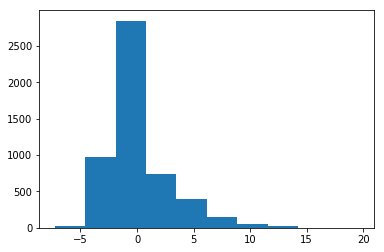

In [51]:
plt.figure()
plt.hist(residuals)

In [52]:
evaluate = full_training_data.loc[full_training_data.player_id.isin(test_ids), :].copy()
evaluate.columns = ['mod_' + col if col in all_features else col for col in evaluate.columns]
evaluate.insert(3, 'predicted_points', preds)
evaluate.insert(4, 'actual_points', test_target)

# Show a random selection
evaluate.sample(20)

,player_id,first_name,second_name,predicted_points,actual_points,team_id,mod_team_difficulty,gameweek,mod_kickoff_hour,mod_kickoff_hour_cos,mod_kickoff_hour_sin,mod_kickoff_weekday,mod_kickoff_weekday_cos,mod_kickoff_weekday_sin,fixture_id,mod_is_home,opponent_team,mod_opponent_team_strength,mod_opponent_difficulty,mod_opponent_strength_ha_overall,mod_opponent_strength_ha_attack,mod_opponent_strength_ha_defence,target_total_points,target_minutes,target_goals_scored,target_goals_conceded,selected,mod_value,mod_value_change,mod_custom_form,mod_transfers_balance,mod_transfers_in,mod_transfers_out,mod_team_strength,mod_team_strength_ha_overall,mod_team_strength_ha_attack,mod_team_strength_ha_defence,mod_prev_assists,mod_prev_attempted_passes,mod_prev_big_chances_created,mod_prev_big_chances_missed,mod_prev_bonus,mod_prev_bps,mod_prev_clean_sheets,mod_prev_clearances_blocks_interceptions,mod_prev_completed_passes,mod_prev_creativity,mod_prev_draw,mod_prev_dribbles,mod_prev_errors_leading_to_goal,mod_prev_errors_leading_to_goal_attempt,mod_prev_fouls,mod_prev_goals_conceded,mod_prev_goals_scored,mod_prev_ict_index,mod_prev_influence,mod_prev_key_passes,mod_prev_kickoff_hour,mod_prev_kickoff_hour_cos,mod_prev_kickoff_hour_sin,mod_prev_kickoff_weekday,mod_prev_kickoff_weekday_cos,mod_prev_kickoff_weekday_sin,mod_prev_loss,mod_prev_minutes,mod_prev_offside,mod_prev_open_play_crosses,mod_prev_opponent_score,mod_prev_opponent_team,mod_prev_own_goals,mod_prev_penalties_conceded,mod_prev_penalties_missed,mod_prev_penalties_saved,mod_prev_recoveries,mod_prev_red_cards,mod_prev_saves,mod_prev_tackled,mod_prev_tackles,mod_prev_target_missed,mod_prev_team_score,mod_prev_threat,mod_prev_total_points,mod_prev_win,mod_prev_winning_goals,mod_prev_yellow_cards,mod_roll_goals_scored,mod_roll_mean_points,mod_roll_minutes,mod_roll_team_conceded,mod_roll_team_points,mod_roll_team_scored,mod_roll_total_points,mod_roll_unique_scorers,mod_team_prev_mean_points,mod_team_prev_result_points,mod_team_prev_total_points,mod_team_prev_unique_scorers,use_row,mod_predict_row,model_row,played_at_all,mod_event_day,mod_position_FWD,mod_position_GKP,mod_position_MID,mod_team_short_BHA,mod_team_short_BOU,mod_team_short_BUR,mod_team_short_CAR,mod_team_short_CHE,mod_team_short_CRY,mod_team_short_EVE,mod_team_short_FUL,mod_team_short_HUD,mod_team_short_LEI,mod_team_short_LIV,mod_team_short_MCI,mod_team_short_MUN,mod_team_short_NEW,mod_team_short_SOU,mod_team_short_TOT,mod_team_short_WAT,mod_team_short_WHU,mod_team_short_WOL,mod_opponent_team_short_BHA,mod_opponent_team_short_BOU,mod_opponent_team_short_BUR,mod_opponent_team_short_CAR,mod_opponent_team_short_CHE,mod_opponent_team_short_CRY,mod_opponent_team_short_EVE,mod_opponent_team_short_FUL,mod_opponent_team_short_HUD,mod_opponent_team_short_LEI,mod_opponent_team_short_LIV,mod_opponent_team_short_MCI,mod_opponent_team_short_MUN,mod_opponent_team_short_NEW,mod_opponent_team_short_SOU,mod_opponent_team_short_TOT,mod_opponent_team_short_WAT,mod_opponent_team_short_WHU,mod_opponent_team_short_WOL,target_ge5,target_gt5_points
441,15,Alex,Iwobi,1.164858,2.0,1,5,25,16,-0.500000,-0.866025,6,0.623490,-0.781831,248,False,13,5.0,4,1350.0,1330.0,1360.0,2.0,65.0,0.0,3.0,84242.0,54.0,0.0,7.333333,-9754.0,1439.0,11193.0,4.0,1320.0,1270.0,1340.0,0.0,23.0,0.0,0.0,0.0,5.0,0.0,0.0,19.0,13.8,False,1.0,0.0,0.0,0.0,1.0,0.0,4.2,7.6,1.0,19.0,0.258819,-9.659258e-01,1.0,0.623490,0.781831,False,45.0,0.0,0.0,1.0,5.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,1.0,0.0,0.0,2.0,21.0,1.0,True,0.0,0.0,0.000000,3.214286,52.333333,0.666667,2.000000,1.333333,45.000000,1.333333,2.857143,3.0,40.0,2.0,True,False,True,True,2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,False,False
8297,298,Marouane,Fellaini,2.947870,2.0,14,3,6,14,-0.866025,-0.500000,5,-0.222521,-0.974928,59,True,20,3.0,4,1130.0,1180.0,1080.0,2.0,90.0,0.0,1.0,56143.0,50.0,0.0,15.000000,17918.0,22914.0,4996.0,4.0,1310.0,1250.0,1310.0,1.0,65.0,0.0,0.0,0.0,24.0,0.0,6.0,53.0,

In [53]:
# Show the top 20 by predicted percentage
evaluate.sort_values('predicted_points', ascending=False).head(20)

,player_id,first_name,second_name,predicted_points,actual_points,team_id,mod_team_difficulty,gameweek,mod_kickoff_hour,mod_kickoff_hour_cos,mod_kickoff_hour_sin,mod_kickoff_weekday,mod_kickoff_weekday_cos,mod_kickoff_weekday_sin,fixture_id,mod_is_home,opponent_team,mod_opponent_team_strength,mod_opponent_difficulty,mod_opponent_strength_ha_overall,mod_opponent_strength_ha_attack,mod_opponent_strength_ha_defence,target_total_points,target_minutes,target_goals_scored,target_goals_conceded,selected,mod_value,mod_value_change,mod_custom_form,mod_transfers_balance,mod_transfers_in,mod_transfers_out,mod_team_strength,mod_team_strength_ha_overall,mod_team_strength_ha_attack,mod_team_strength_ha_defence,mod_prev_assists,mod_prev_attempted_passes,mod_prev_big_chances_created,mod_prev_big_chances_missed,mod_prev_bonus,mod_prev_bps,mod_prev_clean_sheets,mod_prev_clearances_blocks_interceptions,mod_prev_completed_passes,mod_prev_creativity,mod_prev_draw,mod_prev_dribbles,mod_prev_errors_leading_to_goal,mod_prev_errors_leading_to_goal_attempt,mod_prev_fouls,mod_prev_goals_conceded,mod_prev_goals_scored,mod_prev_ict_index,mod_prev_influence,mod_prev_key_passes,mod_prev_kickoff_hour,mod_prev_kickoff_hour_cos,mod_prev_kickoff_hour_sin,mod_prev_kickoff_weekday,mod_prev_kickoff_weekday_cos,mod_prev_kickoff_weekday_sin,mod_prev_loss,mod_prev_minutes,mod_prev_offside,mod_prev_open_play_crosses,mod_prev_opponent_score,mod_prev_opponent_team,mod_prev_own_goals,mod_prev_penalties_conceded,mod_prev_penalties_missed,mod_prev_penalties_saved,mod_prev_recoveries,mod_prev_red_cards,mod_prev_saves,mod_prev_tackled,mod_prev_tackles,mod_prev_target_missed,mod_prev_team_score,mod_prev_threat,mod_prev_total_points,mod_prev_win,mod_prev_winning_goals,mod_prev_yellow_cards,mod_roll_goals_scored,mod_roll_mean_points,mod_roll_minutes,mod_roll_team_conceded,mod_roll_team_points,mod_roll_team_scored,mod_roll_total_points,mod_roll_unique_scorers,mod_team_prev_mean_points,mod_team_prev_result_points,mod_team_prev_total_points,mod_team_prev_unique_scorers,use_row,mod_predict_row,model_row,played_at_all,mod_event_day,mod_position_FWD,mod_position_GKP,mod_position_MID,mod_team_short_BHA,mod_team_short_BOU,mod_team_short_BUR,mod_team_short_CAR,mod_team_short_CHE,mod_team_short_CRY,mod_team_short_EVE,mod_team_short_FUL,mod_team_short_HUD,mod_team_short_LEI,mod_team_short_LIV,mod_team_short_MCI,mod_team_short_MUN,mod_team_short_NEW,mod_team_short_SOU,mod_team_short_TOT,mod_team_short_WAT,mod_team_short_WHU,mod_team_short_WOL,mod_opponent_team_short_BHA,mod_opponent_team_short_BOU,mod_opponent_team_short_BUR,mod_opponent_team_short_CAR,mod_opponent_team_short_CHE,mod_opponent_team_short_CRY,mod_opponent_team_short_EVE,mod_opponent_team_short_FUL,mod_opponent_team_short_HUD,mod_opponent_team_short_LEI,mod_opponent_team_short_LIV,mod_opponent_team_short_MCI,mod_opponent_team_short_MUN,mod_opponent_team_short_NEW,mod_opponent_team_short_SOU,mod_opponent_team_short_TOT,mod_opponent_team_short_WAT,mod_opponent_team_short_WHU,mod_opponent_team_short_WOL,target_ge5,target_gt5_points
4939,172,Gylfi,Sigurdsson,7.451940,10.0,8,3,8,14,-0.866025,-5.000000e-01,5,-0.222521,-0.974928,75,False,11,3.0,2,1110.0,1180.0,1140.0,10.0,90.0,1.0,1.0,124403.0,73.0,0.0,29.333333,46316.0,51462.0,5146.0,3.0,1110.0,1120.0,1230.0,0.0,24.0,0.0,1.0,3.0,37.0,1.0,1.0,19.0,64.1,False,1.0,0.0,0.0,2.0,0.0,2.0,20.7,83.2,5.0,14.0,-8.660254e-01,-5.000000e-01,5.0,-0.222521,-0.974928,False,90.0,1.0,1.0,0.0,9.0,0.0,0.0,1.0,0.0,4.0,0.0,0.0,2.0,0.0,2.0,3.0,60.0,14.0,True,1.0,0.0,1.000000,2.844322,90.000000,1.666667,1.000000,1.333333,39.333333,1.000000,5.285714,3.0,74.0,2.0,True,False,True,True,2,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,True,True
7526,271,David,Silva,7.173132,11.0,13,2,5,14,-0.866025,-5.000000e-01,5,-0.222521,-0.974928,45,True,9,2.0,5,1000.0,1000.0,1000.0,11.0,90.0,1.0,0.0,421399.0,85.0,0.0,23.666667,38067.0,85780.0,47713.0,5.0,1320.0,1320.0,1340.0,0.0,73.0,1.0,1

In [54]:
# Show the top 20 by predicted percentage
evaluate.sort_values('actual_points', ascending=False).head(20)

,player_id,first_name,second_name,predicted_points,actual_points,team_id,mod_team_difficulty,gameweek,mod_kickoff_hour,mod_kickoff_hour_cos,mod_kickoff_hour_sin,mod_kickoff_weekday,mod_kickoff_weekday_cos,mod_kickoff_weekday_sin,fixture_id,mod_is_home,opponent_team,mod_opponent_team_strength,mod_opponent_difficulty,mod_opponent_strength_ha_overall,mod_opponent_strength_ha_attack,mod_opponent_strength_ha_defence,target_total_points,target_minutes,target_goals_scored,target_goals_conceded,selected,mod_value,mod_value_change,mod_custom_form,mod_transfers_balance,mod_transfers_in,mod_transfers_out,mod_team_strength,mod_team_strength_ha_overall,mod_team_strength_ha_attack,mod_team_strength_ha_defence,mod_prev_assists,mod_prev_attempted_passes,mod_prev_big_chances_created,mod_prev_big_chances_missed,mod_prev_bonus,mod_prev_bps,mod_prev_clean_sheets,mod_prev_clearances_blocks_interceptions,mod_prev_completed_passes,mod_prev_creativity,mod_prev_draw,mod_prev_dribbles,mod_prev_errors_leading_to_goal,mod_prev_errors_leading_to_goal_attempt,mod_prev_fouls,mod_prev_goals_conceded,mod_prev_goals_scored,mod_prev_ict_index,mod_prev_influence,mod_prev_key_passes,mod_prev_kickoff_hour,mod_prev_kickoff_hour_cos,mod_prev_kickoff_hour_sin,mod_prev_kickoff_weekday,mod_prev_kickoff_weekday_cos,mod_prev_kickoff_weekday_sin,mod_prev_loss,mod_prev_minutes,mod_prev_offside,mod_prev_open_play_crosses,mod_prev_opponent_score,mod_prev_opponent_team,mod_prev_own_goals,mod_prev_penalties_conceded,mod_prev_penalties_missed,mod_prev_penalties_saved,mod_prev_recoveries,mod_prev_red_cards,mod_prev_saves,mod_prev_tackled,mod_prev_tackles,mod_prev_target_missed,mod_prev_team_score,mod_prev_threat,mod_prev_total_points,mod_prev_win,mod_prev_winning_goals,mod_prev_yellow_cards,mod_roll_goals_scored,mod_roll_mean_points,mod_roll_minutes,mod_roll_team_conceded,mod_roll_team_points,mod_roll_team_scored,mod_roll_total_points,mod_roll_unique_scorers,mod_team_prev_mean_points,mod_team_prev_result_points,mod_team_prev_total_points,mod_team_prev_unique_scorers,use_row,mod_predict_row,model_row,played_at_all,mod_event_day,mod_position_FWD,mod_position_GKP,mod_position_MID,mod_team_short_BHA,mod_team_short_BOU,mod_team_short_BUR,mod_team_short_CAR,mod_team_short_CHE,mod_team_short_CRY,mod_team_short_EVE,mod_team_short_FUL,mod_team_short_HUD,mod_team_short_LEI,mod_team_short_LIV,mod_team_short_MCI,mod_team_short_MUN,mod_team_short_NEW,mod_team_short_SOU,mod_team_short_TOT,mod_team_short_WAT,mod_team_short_WHU,mod_team_short_WOL,mod_opponent_team_short_BHA,mod_opponent_team_short_BOU,mod_opponent_team_short_BUR,mod_opponent_team_short_CAR,mod_opponent_team_short_CHE,mod_opponent_team_short_CRY,mod_opponent_team_short_EVE,mod_opponent_team_short_FUL,mod_opponent_team_short_HUD,mod_opponent_team_short_LEI,mod_opponent_team_short_LIV,mod_opponent_team_short_MCI,mod_opponent_team_short_MUN,mod_opponent_team_short_NEW,mod_opponent_team_short_SOU,mod_opponent_team_short_TOT,mod_opponent_team_short_WAT,mod_opponent_team_short_WHU,mod_opponent_team_short_WOL,target_ge5,target_gt5_points
10908,394,Gerard,Deulofeu,3.369949,23.0,18,2,27,19,0.258819,-9.659258e-01,4,-0.900969,-0.433884,264,False,5,2.0,3,1080.0,1060.0,1090.0,23.0,85.0,3.0,1.0,113800.0,55.0,0.0,1.000000,91.0,8667.0,8576.0,3.0,1110.0,1100.0,1150.0,0.0,33.0,0.0,0.0,0.0,0.0,1.0,3.0,21.0,2.5,False,0.0,0.0,0.0,1.0,0.0,0.0,3.7,2.8,0.0,15.0,-0.707107,-7.071068e-01,5.0,-0.222521,-0.974928,False,80.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,7.0,0.0,0.0,1.0,32.0,3.0,True,0.0,0.0,0.000000,3.478022,69.666667,0.666667,1.333333,0.666667,46.666667,0.666667,4.357143,3.0,61.0,1.0,True,False,True,True,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,True,True
6849,246,Virgil,van Dijk,3.106428,20.0,12,3,28,20,0.500000,-8.660254e-01,2,-0.222521,0.974928,277,True,18,3.0,5,1100.0,1100.0,1130.0,20.0,90.0,2.0,0.0,1762402.0,65.0,0.0,24.000000,32036.0,42299.0,10263.0,5.0,1330.0,1330.0,1330.0,0.0,76.0,0.0,0.0,1.0,

(array([1.27934498e-03, 1.43997384e-01, 1.42149442e-01, 3.88067976e-02,
        2.99935322e-02, 9.09756427e-03, 2.70083939e-03, 1.99009218e-03,
        2.84298883e-04, 7.10747209e-05]),
 array([-4. , -1.3,  1.4,  4.1,  6.8,  9.5, 12.2, 14.9, 17.6, 20.3, 23. ]),
 <a list of 10 Patch objects>)

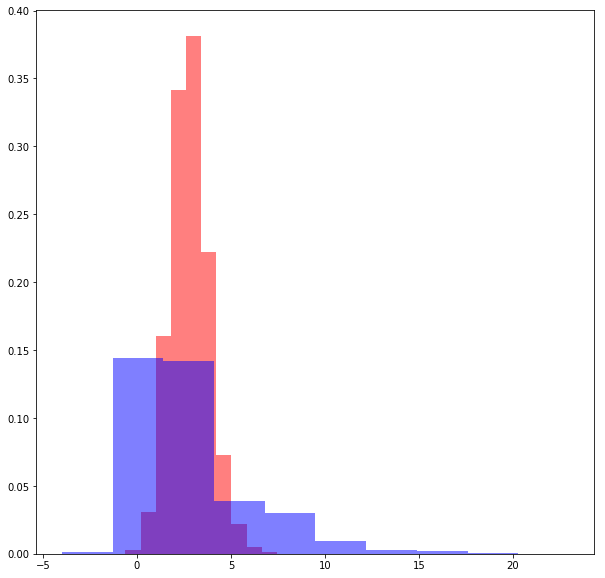

In [55]:
plt.figure(figsize=(10, 10))
plt.hist(evaluate.predicted_points, density=True, alpha=0.5, color='red')
plt.hist(evaluate.actual_points, density=True, alpha=0.5, color='blue')

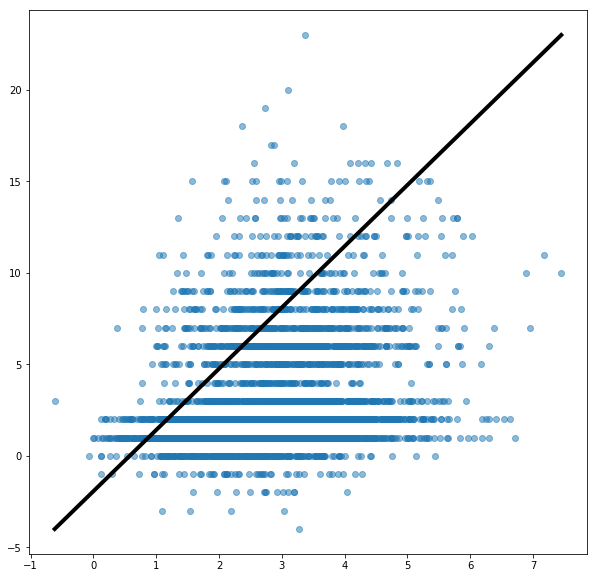

In [58]:
plt.figure(figsize=(10, 10))
plt.scatter(evaluate.predicted_points, evaluate.actual_points, alpha=0.5)
plt.plot([evaluate.predicted_points.min(), evaluate.predicted_points.max()],
         [evaluate.actual_points.min(), evaluate.actual_points.max()], color='black', linewidth=4)

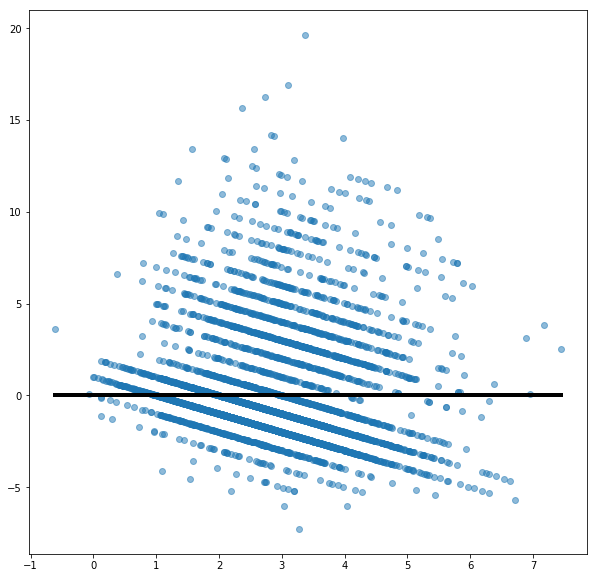

In [60]:
plt.figure(figsize=(10, 10))
plt.scatter(evaluate.predicted_points, residuals, alpha=0.5)
plt.plot([evaluate.predicted_points.min(), evaluate.predicted_points.max()], [0, 0], color='black', linewidth=4)

In [69]:
train_ids, test_ids = train_test_split(training_player_ids.unique(), test_size=0.7)
train_data = full_training_data.loc[full_training_data.player_id.isin(train_ids), all_features].copy()
train_target = full_training_data.loc[full_training_data.player_id.isin(train_ids), 'target_total_points']
test_data = full_training_data.loc[full_training_data.player_id.isin(test_ids), all_features].copy()
test_target = full_training_data.loc[full_training_data.player_id.isin(test_ids), 'target_total_points']

column_names = list(train_data.columns)

# Simple scaling of the data
ss = StandardScaler()

X_train = ss.fit_transform(train_data.values)
X_test = ss.transform(test_data.values)
y_train = train_target.values
y_test = test_target.values

y_train[y_train < 0] = 0
y_test[y_test < 0] = 0

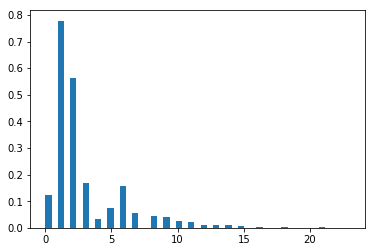

In [71]:
_ = plt.hist(y_train, density=True, bins=np.linspace(np.min(y_train), np.max(y_train)))

In [81]:
print(f"Ratio of mean to variance of response: {np.mean(y_train)/np.var(y_train):.2f}")

Ratio of mean to variance of response: 0.32


In [86]:
import statsmodels.api as sm
from statsmodels.genmod.families import Poisson, NegativeBinomial

pca_lim = PCA(n_components=50)
X_train_pca = pca_lim.fit_transform(X_train)
X_test_pca = pca_lim.transform(X_test)


reg_poisson = sm.GLM(y_train, X_train_pca, family = Poisson()).fit()
reg_poisson.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                 2141
Model:                            GLM   Df Residuals:                     2091
Model Family:                 Poisson   Df Model:                           49
Link Function:                    log   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -6807.0
Date:                Sat, 10 Aug 2019   Deviance:                       8151.4
Time:                        14:47:09   Pearson chi2:                 2.07e+04
No. Iterations:                     6                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.1233      0.005     25.804      0.000       0.114       0.133
x2             0.0709      0.007     10.131      0.000       0.057       0.085
x3            -0.1652      0.009    -17.935      0.000      -0.183      -0.147
x4            -0.0119      0.009     -1.359      0.174      -0.029       0.005
x5            -0.0753      0.008     -8.895      0.000      -0.092      -0.059
x6             0.0598      0.008      7.355      0.000       0.044       0.076
x7            -0.0099      0.010     -1.018      0.308      -0.029       0.009
x8             0.0025      0.010      0.252      0.801      -0.017       0.022
x9            -0.1080      0.012     -9.233      0.000      -0.131      -0.085
x10           -0.0062      0.012     -0.522      0.602      -0.030       0.017
x11            0.1343      0.012     11.559      0.000       0.112       0.157
x12            0.0074      0.012      0.627      0.531      -0.016       0.030
x13           -0.0954      0.012     -7.885      0.000      -0.119      -0.072
x14           -0.0123      0.015     -0.820      0.412      -0.042       0.017
x15           -0.0412      0.014     -2.977      0.003      -0.068      -0.014
x16            0.1083      0.015      7.041      0.000       0.078       0.138
x17           -0.0006      0.015     -0.044      0.965      -0.029       0.028
x18           -0.0366      0.016     -2.255      0.024      -0.068      -0.005
x19           -0.1463      0.016     -9.333      0.000      -0.177      -0.116
x20            0.0532      0.016      3.237      0.001       0.021       0.085
x21           -0.0433      0.016     -2.660      0.008      -0.075      -0.011
x22            0.0139      0.017      0.822      0.411      -0.019       0.047
x23            0.0585      0.017      3.491      0.000       0.026       0.091
x24            0.1037      0.016      6.359      0.000       0.072       0.136
x25           -0.0127      0.018     -0.713      0.476      -0.048       0.022
x26            0.0454      0.018      2.458      0.014       0.009       0.082
x27           -0.0306      0.017     -1.771      0.077      -0.064       0.003
x28            0.0010      0.018      0.058      0.954      -0.033       0.035
x29           -0.0551      0.018     -3.071      0.002      -0.090      -0.020
x30            0.0608      0.020      3.024      0.002       0.021       0.100
x31            0.0095      0.018      0.534      0.594      -0.025       0.044
x32            0.0436      0.019      2.339      0.019       0.007       0.080
x33           -0.0008      0.018     -0.043      0.966      -0.036       0.035
x34           -0.0199      0.020     -1.009      0.313      -0.059       0.019
x35           -0.0490      0.020     -2.486      0.013      -0.088      -0.010
x36           -0.0116      0.019     -0.623      0.533      -0.048       0.025
x37            0.0107      0.019      0.565      0.572      -0.027       0.048
x3

In [87]:
reg_poisson.predict(X_test_pca)

array([4.934621  , 2.43312234, 2.06444498, ..., 0.84784109, 0.53916311,
       0.58556489])

In [88]:
reg_negbin = sm.GLM(y_train, X_train_pca, family = NegativeBinomial()).fit()
reg_negbin.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                 2141
Model:                            GLM   Df Residuals:                     2091
Model Family:        NegativeBinomial   Df Model:                           49
Link Function:                    log   Scale:              7.7775772864783566
Method:                          IRLS   Log-Likelihood:                -5817.0
Date:                Sat, 10 Aug 2019   Deviance:                       3511.3
Time:                        14:53:35   Pearson chi2:                 1.63e+04
No. Iterations:                   100                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.1183      0.023      5.114      0.000       0.073       0.164
x2             0.0296      0.030      0.978      0.328      -0.030       0.089
x3            -0.1102      0.038     -2.882      0.004      -0.185      -0.035
x4             0.0105      0.039      0.267      0.790      -0.067       0.088
x5            -0.0705      0.040     -1.780      0.075      -0.148       0.007
x6             0.0492      0.040      1.226      0.220      -0.029       0.128
x7            -0.0701      0.044     -1.583      0.113      -0.157       0.017
x8             0.0039      0.047      0.082      0.935      -0.089       0.096
x9            -0.0768      0.054     -1.414      0.157      -0.183       0.030
x10            0.0115      0.055      0.209      0.835      -0.096       0.119
x11            0.0838      0.056      1.497      0.134      -0.026       0.194
x12            0.1209      0.058      2.070      0.038       0.006       0.235
x13           -0.0980      0.060     -1.639      0.101      -0.215       0.019
x14            0.0107      0.066      0.161      0.872      -0.119       0.141
x15           -0.0508      0.065     -0.778      0.437      -0.179       0.077
x16            0.1343      0.069      1.940      0.052      -0.001       0.270
x17           -0.0003      0.069     -0.004      0.997      -0.135       0.135
x18           -0.1029      0.073     -1.409      0.159      -0.246       0.040
x19           -0.1241      0.071     -1.750      0.080      -0.263       0.015
x20            0.0072      0.073      0.099      0.921      -0.136       0.150
x21        -1.395e-05      0.071     -0.000      1.000      -0.140       0.139
x22           -0.1370      0.076     -1.811      0.070      -0.285       0.011
x23           -0.0951      0.075     -1.263      0.206      -0.243       0.052
x24           -0.0138      0.075     -0.185      0.854      -0.160       0.133
x25            0.0594      0.077      0.776      0.438      -0.091       0.210
x26            0.0540      0.080      0.678      0.498      -0.102       0.210
x27            0.0892      0.076      1.178      0.239      -0.059       0.238
x28            0.0570      0.077      0.742      0.458      -0.094       0.208
x29           -0.0790      0.078     -1.012      0.311      -0.232       0.074
x30            0.1235      0.081      1.528      0.126      -0.035       0.282
x31           -0.1732      0.079     -2.182      0.029      -0.329      -0.018
x32            0.0605      0.081      0.743      0.457      -0.099       0.220
x33           -0.0346      0.080     -0.431      0.667      -0.192       0.123
x34            0.0534      0.082      0.649      0.516      -0.108       0.215
x35           -0.0839      0.083     -1.014      0.311      -0.246       0.078
x36            0.1200      0.079      1.517      0.129      -0.035       0.275
x37            0.0263      0.083      0.316      0.752      -0.137       0.189
x3

In [95]:
preds_nb_test = reg_poisson.predict(X_train_pca)
#preds_nb_test = reg_negbin.predict(X_test_pca)
nb_eval = full_training_data.loc[full_training_data.player_id.isin(train_ids), :].copy()
nb_eval.columns = ['mod_' + col if col in all_features else col for col in nb_eval.columns]
nb_eval.insert(3, 'predicted_points', preds_nb_test)
nb_eval.insert(4, 'actual_points', y_train)

# Show a random selection
evaluate.sample(20)

,player_id,first_name,second_name,predicted_points,actual_points,team_id,mod_team_difficulty,gameweek,mod_kickoff_hour,mod_kickoff_hour_cos,mod_kickoff_hour_sin,mod_kickoff_weekday,mod_kickoff_weekday_cos,mod_kickoff_weekday_sin,fixture_id,mod_is_home,opponent_team,mod_opponent_team_strength,mod_opponent_difficulty,mod_opponent_strength_ha_overall,mod_opponent_strength_ha_attack,mod_opponent_strength_ha_defence,target_total_points,target_minutes,target_goals_scored,target_goals_conceded,selected,mod_value,mod_value_change,mod_custom_form,mod_transfers_balance,mod_transfers_in,mod_transfers_out,mod_team_strength,mod_team_strength_ha_overall,mod_team_strength_ha_attack,mod_team_strength_ha_defence,mod_prev_assists,mod_prev_attempted_passes,mod_prev_big_chances_created,mod_prev_big_chances_missed,mod_prev_bonus,mod_prev_bps,mod_prev_clean_sheets,mod_prev_clearances_blocks_interceptions,mod_prev_completed_passes,mod_prev_creativity,mod_prev_draw,mod_prev_dribbles,mod_prev_errors_leading_to_goal,mod_prev_errors_leading_to_goal_attempt,mod_prev_fouls,mod_prev_goals_conceded,mod_prev_goals_scored,mod_prev_ict_index,mod_prev_influence,mod_prev_key_passes,mod_prev_kickoff_hour,mod_prev_kickoff_hour_cos,mod_prev_kickoff_hour_sin,mod_prev_kickoff_weekday,mod_prev_kickoff_weekday_cos,mod_prev_kickoff_weekday_sin,mod_prev_loss,mod_prev_minutes,mod_prev_offside,mod_prev_open_play_crosses,mod_prev_opponent_score,mod_prev_opponent_team,mod_prev_own_goals,mod_prev_penalties_conceded,mod_prev_penalties_missed,mod_prev_penalties_saved,mod_prev_recoveries,mod_prev_red_cards,mod_prev_saves,mod_prev_tackled,mod_prev_tackles,mod_prev_target_missed,mod_prev_team_score,mod_prev_threat,mod_prev_total_points,mod_prev_win,mod_prev_winning_goals,mod_prev_yellow_cards,mod_roll_goals_scored,mod_roll_mean_points,mod_roll_minutes,mod_roll_team_conceded,mod_roll_team_points,mod_roll_team_scored,mod_roll_total_points,mod_roll_unique_scorers,mod_team_prev_mean_points,mod_team_prev_result_points,mod_team_prev_total_points,mod_team_prev_unique_scorers,use_row,mod_predict_row,model_row,played_at_all,mod_event_day,mod_position_FWD,mod_position_GKP,mod_position_MID,mod_team_short_BHA,mod_team_short_BOU,mod_team_short_BUR,mod_team_short_CAR,mod_team_short_CHE,mod_team_short_CRY,mod_team_short_EVE,mod_team_short_FUL,mod_team_short_HUD,mod_team_short_LEI,mod_team_short_LIV,mod_team_short_MCI,mod_team_short_MUN,mod_team_short_NEW,mod_team_short_SOU,mod_team_short_TOT,mod_team_short_WAT,mod_team_short_WHU,mod_team_short_WOL,mod_opponent_team_short_BHA,mod_opponent_team_short_BOU,mod_opponent_team_short_BUR,mod_opponent_team_short_CAR,mod_opponent_team_short_CHE,mod_opponent_team_short_CRY,mod_opponent_team_short_EVE,mod_opponent_team_short_FUL,mod_opponent_team_short_HUD,mod_opponent_team_short_LEI,mod_opponent_team_short_LIV,mod_opponent_team_short_MCI,mod_opponent_team_short_MUN,mod_opponent_team_short_NEW,mod_opponent_team_short_SOU,mod_opponent_team_short_TOT,mod_opponent_team_short_WAT,mod_opponent_team_short_WHU,mod_opponent_team_short_WOL,target_ge5,target_gt5_points
2680,94,Joe,Bennett,1.971349,1.0,5,4,24,19,0.258819,-9.659258e-01,1,0.623490,0.781831,231,False,1,4.0,2,1320.0,1270.0,1340.0,1.0,90.0,0.0,2.0,26732.0,44.0,0.0,10.333333,-435.0,157.0,592.0,2.0,1080.0,1060.0,1090.0,0.0,38.0,0.0,0.0,0.0,16.0,0.0,3.0,31.0,12.2,True,3.0,0.0,0.0,0.0,3.0,0.0,4.2,26.2,1.0,15.0,-0.707107,-7.071068e-01,5.0,-0.222521,-0.974928,False,90.0,0.0,0.0,0.0,15.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,1.0,0.0,0.0,0.0,4.0,1.0,False,0.0,0.0,0.000000,2.265568,60.000000,2.000000,0.333333,0.000000,30.333333,0.000000,1.428571,0.0,20.0,0.0,True,False,True,True,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False,False
1144,38,Jordon,Ibe,2.407601,1.0,2,4,28,19,0.258819,-9.659258e-01,2,-0.222521,0.974928,271,False,1,4.0,2,1320.0,1270.0,1340.0,1.0,55.0,0.0,3.0,13298.0,50.0,0.0,4.666667,48.0,154.0,106.0,3.0,1130.0,1100.0,1130.0,0.0,26.0,0.0,0.0,0.0,9.0,0.0,1.0,20.0,18.6,Tru

Text(0,0.5,'Actual')

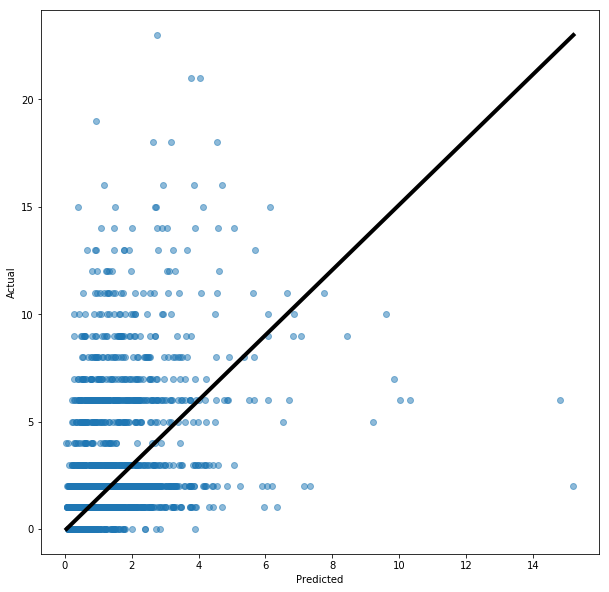

In [96]:
plt.figure(figsize=(10, 10))
plt.scatter(nb_eval.predicted_points, nb_eval.actual_points, alpha=0.5)
plt.plot([nb_eval.predicted_points.min(), nb_eval.predicted_points.max()],
         [nb_eval.actual_points.min(), nb_eval.actual_points.max()], color='black', linewidth=4)
plt.xlabel('Predicted')
plt.ylabel('Actual')

# MIXED EFFECTS

In [43]:
list(full_training_data.columns)

['player_id',
 'first_name',
 'second_name',
 'team_id',
 'team_difficulty',
 'gameweek',
 'kickoff_hour',
 'kickoff_hour_cos',
 'kickoff_hour_sin',
 'kickoff_weekday',
 'kickoff_weekday_cos',
 'kickoff_weekday_sin',
 'fixture_id',
 'is_home',
 'opponent_team',
 'opponent_team_strength',
 'opponent_difficulty',
 'opponent_strength_ha_overall',
 'opponent_strength_ha_attack',
 'opponent_strength_ha_defence',
 'target_total_points',
 'target_minutes',
 'target_goals_scored',
 'target_goals_conceded',
 'selected',
 'value',
 'value_change',
 'custom_form',
 'transfers_balance',
 'transfers_in',
 'transfers_out',
 'team_strength',
 'team_strength_ha_overall',
 'team_strength_ha_attack',
 'team_strength_ha_defence',
 'prev_assists',
 'prev_attempted_passes',
 'prev_big_chances_created',
 'prev_big_chances_missed',
 'prev_bonus',
 'prev_bps',
 'prev_clean_sheets',
 'prev_clearances_blocks_interceptions',
 'prev_completed_passes',
 'prev_creativity',
 'prev_draw',
 'prev_dribbles',
 'prev_err

In [67]:
all_features = ['is_home',
                'team_difficulty',
                'opponent_team_strength',
                'opponent_difficulty',
                'opponent_strength_ha_overall',
                'opponent_strength_ha_attack',
                'opponent_strength_ha_defence',
                'value',
                'value_change',
                'team_strength',
                 'team_strength_ha_overall',
                 'team_strength_ha_attack',
                 'team_strength_ha_defence',
                'custom_form',
                'prev_bps',
                'prev_ict_index',
                'prev_minutes',
                'prev_total_points',                
                 'position_FWD',
                 'position_GKP',
                 'position_MID'
               ]

train_data, test_data, train_target, test_target, train_index, test_index = train_test_split(full_training_data[all_features],
                                                                                              full_training_data['target_gt5_points'],
                                                                                              full_training_data.index)

train_groups = full_training_data.loc[full_training_data.index.isin(train_index), 'player_id']
test_groups = full_training_data.loc[full_training_data.index.isin(test_index), 'player_id']
column_names = list(train_data.columns)

# Simple scaling of the data
ss = StandardScaler()

X_train = ss.fit_transform(train_data.values)
X_test = ss.transform(test_data.values)
y_train = train_target.values
y_test = test_target.values
Z_train = np.ones((X_train.shape[0], 1))
Z_test = np.ones((X_test.shape[0], 1))

In [68]:
import statsmodels.formula.api as smf
import statsmodels.api as sm


md = sm.MixedLM(y_train, X_train, groups=train_groups,
               exog_re=Z_train)
mdf = md.fit()
print(mdf.summary())

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: y         
No. Observations: 5555    Method:             REML      
No. Groups:       384     Scale:              0.1545    
Min. group size:  1       Likelihood:         -3063.0219
Max. group size:  30      Converged:          Yes       
Mean group size:  14.5                                  
--------------------------------------------------------
             Coef.  Std.Err.    z    P>|z| [0.025 0.975]
--------------------------------------------------------
x1            0.014    0.008   1.705 0.088 -0.002  0.029
x2           -0.011    0.018  -0.581 0.561 -0.046  0.025
x3           -0.012    0.018  -0.653 0.513 -0.047  0.023
x4           -0.008    0.017  -0.452 0.652 -0.042  0.026
x5            0.003    0.028   0.100 0.920 -0.052  0.058
x6           -0.040    0.016  -2.462 0.014 -0.071 -0.008
x7            0.005    0.017   0.308 0.758 -0.028  0.038
x8            0.071    0.008   9.155 0.00

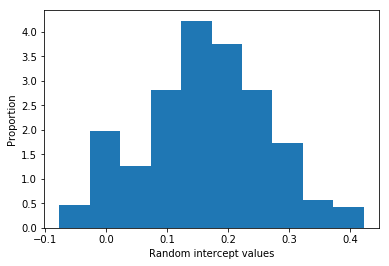

In [69]:
ref_dict = {}
for k, v in mdf.random_effects.items():
    ref_dict[k] = float(v.values)
plt.hist(ref_dict.values(), density=True)
plt.xlabel('Random intercept values')
plt.ylabel('Proportion')
plt.show()

In [70]:
r_effs = np.array(list(ref_dict.values()))
r_eff_mean = np.mean(r_effs)
mlm_preds_train = X_train.dot(mdf.fe_params) + train_groups.map(ref_dict)
mlm_preds_test = X_test.dot(mdf.fe_params) + test_groups.map(ref_dict).fillna(r_eff_mean)

In [71]:
preds_train = 1/(1+np.exp(-mlm_preds_train))
preds_test = 1/(1+np.exp(-mlm_preds_test))

In [74]:
mem_eval = full_training_data.loc[full_training_data.index.isin(test_index), :].copy()
mem_eval.columns = ['mod_' + col if col in all_features else col for col in mem_eval.columns]
mem_eval.insert(3, 'prob_of_scoring_more_than_5', preds_test)
mem_eval.insert(4, 'total_points_scored', mem_eval.target_total_points)
mem_eval.insert(5, 'correct', ((mem_eval.prob_of_scoring_more_than_5 > 0.5) & 
                      (mem_eval.target_total_points >= 5)) | ((mem_eval.prob_of_scoring_more_than_5 < 0.5) & 
                      (mem_eval.target_total_points < 5)))

# Show a random selection
mem_eval.sample(20)

,player_id,first_name,second_name,prob_of_scoring_more_than_5,total_points_scored,correct,team_id,mod_team_difficulty,gameweek,kickoff_hour,kickoff_hour_cos,kickoff_hour_sin,kickoff_weekday,kickoff_weekday_cos,kickoff_weekday_sin,fixture_id,mod_is_home,opponent_team,mod_opponent_team_strength,mod_opponent_difficulty,mod_opponent_strength_ha_overall,mod_opponent_strength_ha_attack,mod_opponent_strength_ha_defence,target_total_points,target_minutes,target_goals_scored,target_goals_conceded,selected,mod_value,mod_value_change,mod_custom_form,transfers_balance,transfers_in,transfers_out,mod_team_strength,mod_team_strength_ha_overall,mod_team_strength_ha_attack,mod_team_strength_ha_defence,prev_assists,prev_attempted_passes,prev_big_chances_created,prev_big_chances_missed,prev_bonus,mod_prev_bps,prev_clean_sheets,prev_clearances_blocks_interceptions,prev_completed_passes,prev_creativity,prev_draw,prev_dribbles,prev_errors_leading_to_goal,prev_errors_leading_to_goal_attempt,prev_fouls,prev_goals_conceded,prev_goals_scored,mod_prev_ict_index,prev_influence,prev_key_passes,prev_kickoff_hour,prev_kickoff_hour_cos,prev_kickoff_hour_sin,prev_kickoff_weekday,prev_kickoff_weekday_cos,prev_kickoff_weekday_sin,prev_loss,mod_prev_minutes,prev_offside,prev_open_play_crosses,prev_opponent_score,prev_opponent_team,prev_own_goals,prev_penalties_conceded,prev_penalties_missed,prev_penalties_saved,prev_recoveries,prev_red_cards,prev_saves,prev_tackled,prev_tackles,prev_target_missed,prev_team_score,prev_threat,mod_prev_total_points,prev_win,prev_winning_goals,prev_yellow_cards,roll_goals_scored,roll_mean_points,roll_minutes,roll_team_conceded,roll_team_points,roll_team_scored,roll_total_points,roll_unique_scorers,team_prev_mean_points,team_prev_result_points,team_prev_total_points,team_prev_unique_scorers,use_row,predict_row,model_row,played_at_all,event_day,mod_position_FWD,mod_position_GKP,mod_position_MID,team_short_BHA,team_short_BOU,team_short_BUR,team_short_CAR,team_short_CHE,team_short_CRY,team_short_EVE,team_short_FUL,team_short_HUD,team_short_LEI,team_short_LIV,team_short_MCI,team_short_MUN,team_short_NEW,team_short_SOU,team_short_TOT,team_short_WAT,team_short_WHU,team_short_WOL,opponent_team_short_BHA,opponent_team_short_BOU,opponent_team_short_BUR,opponent_team_short_CAR,opponent_team_short_CHE,opponent_team_short_CRY,opponent_team_short_EVE,opponent_team_short_FUL,opponent_team_short_HUD,opponent_team_short_LEI,opponent_team_short_LIV,opponent_team_short_MCI,opponent_team_short_MUN,opponent_team_short_NEW,opponent_team_short_SOU,opponent_team_short_TOT,opponent_team_short_WAT,opponent_team_short_WHU,opponent_team_short_WOL,target_ge5,target_gt5_points
13079,466,Yves,Bissouma,0.550278,3.0,False,3,2,29,15,-0.707107,-7.071068e-01,5,-0.222521,-0.974928,282,True,10,2.0,2,1010.0,1030.0,990.0,3.0,84.0,0.0,0.0,1495.0,46.0,0.0,3.000000,48.0,73.0,25.0,2.0,1030.0,1040.0,1010.0,0.0,26.0,0.0,0.0,0.0,3.0,0.0,0.0,24.0,4.0,True,1.0,0.0,0.0,0.0,1.0,0.0,1.1,0.4,0.0,19.0,2.588190e-01,-9.659258e-01,1.0,0.623490,0.781831,False,39.0,0.0,0.0,1.0,11.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,1.0,0.0,1.0,1.0,7.0,1.0,False,0.0,0.0,0.000000,2.623016,51.000000,1.666667,0.333333,0.666667,34.000000,0.666667,1.857143,0.0,26.0,1.0,True,False,True,True,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,False,False
13496,479,Matt,Targett,0.566680,1.0,False,16,3,25,15,-0.707107,-7.071068e-01,5,-0.222521,-0.974928,242,False,4,3.0,2,1100.0,1030.0,1040.0,1.0,90.0,0.0,1.0,14934.0,42.0,0.0,14.333333,2771.0,3380.0,609.0,2.0,1060.0,1070.0,1100.0,1.0,36.0,1.0,0.0,2.0,24.0,0.0,3.0,26.0,36.6,True,0.0,0.0,0.0,0.0,1.0,0.0,7.0,27.4,2.0,19.0,2.588190e-01,-9.659258e-01,2.0,-0.222521,0.974928,False,90.0,0.0,1.0,1.0,7.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,5.0,2.0,0.0,1.0,6.0,7.0,False,0.0,0.0,0.000000,2.476190,71.333333,1.000000,2.333333,1.666667,34.666667,1.333333,2.571429,1.0,36.0,1.0,True,False,True,True,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0

In [75]:
mem_eval.sort_values('prob_of_scoring_more_than_5', ascending=False).head(20)

,player_id,first_name,second_name,prob_of_scoring_more_than_5,total_points_scored,correct,team_id,mod_team_difficulty,gameweek,kickoff_hour,kickoff_hour_cos,kickoff_hour_sin,kickoff_weekday,kickoff_weekday_cos,kickoff_weekday_sin,fixture_id,mod_is_home,opponent_team,mod_opponent_team_strength,mod_opponent_difficulty,mod_opponent_strength_ha_overall,mod_opponent_strength_ha_attack,mod_opponent_strength_ha_defence,target_total_points,target_minutes,target_goals_scored,target_goals_conceded,selected,mod_value,mod_value_change,mod_custom_form,transfers_balance,transfers_in,transfers_out,mod_team_strength,mod_team_strength_ha_overall,mod_team_strength_ha_attack,mod_team_strength_ha_defence,prev_assists,prev_attempted_passes,prev_big_chances_created,prev_big_chances_missed,prev_bonus,mod_prev_bps,prev_clean_sheets,prev_clearances_blocks_interceptions,prev_completed_passes,prev_creativity,prev_draw,prev_dribbles,prev_errors_leading_to_goal,prev_errors_leading_to_goal_attempt,prev_fouls,prev_goals_conceded,prev_goals_scored,mod_prev_ict_index,prev_influence,prev_key_passes,prev_kickoff_hour,prev_kickoff_hour_cos,prev_kickoff_hour_sin,prev_kickoff_weekday,prev_kickoff_weekday_cos,prev_kickoff_weekday_sin,prev_loss,mod_prev_minutes,prev_offside,prev_open_play_crosses,prev_opponent_score,prev_opponent_team,prev_own_goals,prev_penalties_conceded,prev_penalties_missed,prev_penalties_saved,prev_recoveries,prev_red_cards,prev_saves,prev_tackled,prev_tackles,prev_target_missed,prev_team_score,prev_threat,mod_prev_total_points,prev_win,prev_winning_goals,prev_yellow_cards,roll_goals_scored,roll_mean_points,roll_minutes,roll_team_conceded,roll_team_points,roll_team_scored,roll_total_points,roll_unique_scorers,team_prev_mean_points,team_prev_result_points,team_prev_total_points,team_prev_unique_scorers,use_row,predict_row,model_row,played_at_all,event_day,mod_position_FWD,mod_position_GKP,mod_position_MID,team_short_BHA,team_short_BOU,team_short_BUR,team_short_CAR,team_short_CHE,team_short_CRY,team_short_EVE,team_short_FUL,team_short_HUD,team_short_LEI,team_short_LIV,team_short_MCI,team_short_MUN,team_short_NEW,team_short_SOU,team_short_TOT,team_short_WAT,team_short_WHU,team_short_WOL,opponent_team_short_BHA,opponent_team_short_BOU,opponent_team_short_BUR,opponent_team_short_CAR,opponent_team_short_CHE,opponent_team_short_CRY,opponent_team_short_EVE,opponent_team_short_FUL,opponent_team_short_HUD,opponent_team_short_LEI,opponent_team_short_LIV,opponent_team_short_MCI,opponent_team_short_MUN,opponent_team_short_NEW,opponent_team_short_SOU,opponent_team_short_TOT,opponent_team_short_WAT,opponent_team_short_WHU,opponent_team_short_WOL,target_ge5,target_gt5_points
9844,356,Ben,Davies,0.679969,2.0,False,17,4,13,17,-2.588190e-01,-0.965926,5,-0.222521,-0.974928,127,True,6,4.0,4,1260.0,1270.0,1320.0,2.0,90.0,0.0,1.0,127513.0,56.0,0.0,16.000000,366.0,3536.0,3170.0,5.0,1330.0,1270.0,1320.0,0.0,60.0,0.0,0.0,0.0,25.0,1.0,5.0,50.0,29.2,True,0.0,0.0,0.0,0.0,0.0,0.0,5.7,24.4,2.0,17.0,-2.588190e-01,-9.659258e-01,5.0,-0.222521,-0.974928,False,90.0,0.0,1.0,1.0,7.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,1.0,1.0,3.0,6.0,False,0.0,0.0,0.000000,3.095238,90.000000,1.000000,2.000000,1.333333,43.333333,1.333333,4.642857,3.0,65.0,1.0,True,False,True,True,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False,False
11567,417,Marko,Arnautovic,0.672366,13.0,True,19,2,21,19,2.588190e-01,-0.965926,2,-0.222521,0.974928,209,True,3,2.0,3,1030.0,1040.0,1010.0,13.0,90.0,2.0,2.0,429433.0,69.0,0.0,2.666667,48690.0,60084.0,11394.0,3.0,1100.0,1090.0,1120.0,0.0,31.0,0.0,0.0,0.0,8.0,0.0,0.0,22.0,12.6,True,1.0,0.0,0.0,0.0,2.0,0.0,1.6,3.0,1.0,14.0,-8.660254e-01,-5.000000e-01,6.0,0.623490,-0.781831,False,72.0,1.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,2.0,False,0.0,0.0,0.000000,1.809524,24.000000,1.666667,1.000000,0.666667,25.333333,0.333333,1.071429,0.0,15.0,0.0,True,False,True,True,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,